In [1]:
import argparse
import json
import os
import time
import warnings

import tensorflow_datasets as tfds
import torch
from PIL import Image
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor
from utils import NumpyFloatValuesEncoder, post_process_caption

2024-09-30 17:44:57.405689: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 17:44:57.405767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 17:44:57.406944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 17:44:57.413800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 17:44:58.200991: W tensorflow/compiler/tf2

In [2]:
result_path = './bboxes'
bbox_json_path = os.path.join(result_path, f"results_0_bboxes.json")

print("Loading data...")
split_percents = 100
start = 0
end = 1

Loading data...


In [4]:
import tensorflow as tf
local_path="/home/lixiang/codebase/embodied-CoT/datasets/libero/libero_spatial_no_noops/1.0.0"
with tf.device('/GPU:1'):
    b = tfds.builder_from_directory(builder_dir=local_path)
    ds = b.as_dataset(split=f'train[{start}%:{end}%]')
print("Done.")

print("Loading Prismatic descriptions...")
results_json_path = "/home/lixiang/codebase/embodied-CoT/scripts/generate_embodied_data/bounding_boxes/descriptions/full_descriptions.json"
with open(results_json_path, "r") as f:
    results_json = json.load(f)
print("Done.")

2024-09-30 17:45:23.874903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21744 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-09-30 17:45:23.876338: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21744 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:25:00.0, compute capability: 8.6
2024-09-30 17:45:23.877432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 21744 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6
2024-09-30 17:45:23.878533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21744 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

Done.
Loading Prismatic descriptions...
Done.


In [5]:
print(f"Loading gDINO to device...")
model_id = "IDEA-Research/grounding-dino-base"
device = "cuda:0"

processor = AutoProcessor.from_pretrained(model_id, size={"shortest_edge": 256, "longest_edge": 256})
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
print("Done.")

Loading gDINO to device...


/home/lixiang/anaconda3/envs/robot/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not load the custom kernel for multi-scale deformable attention: Error building extension 'MultiScaleDeformableAttention': [1/2] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output ms_deform_attn_cuda.cuda.o.d -DTORCH_EXTENSION_NAME=MultiScaleDeformableAttention -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -I/home/lixiang/anaconda3/envs/robot/lib/python3.10/site-packages/transformers/kernels/deformable_detr -isystem /home/lixiang/anaconda3/envs/robot/lib/python3.10/site-packages/torch/include -isystem /home/lixiang/anaconda3/envs/robot/lib/python3.10/site-pac

Done.


In [6]:
BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.2

bbox_results_json = {}
for ep_idx, episode in enumerate(ds):
    episode_id = ep_idx
    file_path = episode["episode_metadata"]["file_path"].numpy().decode()
    print(f"ID 0 starting ep: {episode_id}, {file_path}")
    if file_path not in bbox_results_json.keys():
        bbox_results_json[file_path] = {}

    episode_json = results_json[file_path][str(episode_id)]
    description = episode_json["caption"]

    break

print(description)

ID 0 starting ep: 0, /iris/u/moojink/prismatic-dev/LIBERO/libero/datasets/regenerated--no_noops/libero_spatial/pick_up_the_black_bowl_next_to_the_cookie_box_and_place_it_on_the_plate_demo.hdf5
A black bowl is next to a cookie box, and a plate is nearby. The robot should pick up the black bowl and place it on the plate.


In [7]:
start = time.time()
bboxes_list = []
for step_idx, step in enumerate(episode["steps"]):
    if step_idx == 0:
        lang_instruction = step["language_instruction"].numpy().decode()
    #image = Image.fromarray(step["observation"]["image_0"].numpy())
    image = Image.fromarray(step["observation"]["image"].numpy()) #for libero dataset
    break

In [21]:
image_debug = Image.open('/home/lixiang/codebase/embodied-CoT/scripts/generate_embodied_data/bounding_boxes/output.png')

In [22]:
inputs = processor(
    images=image_debug,
    text=post_process_caption(description, lang_instruction),
    return_tensors="pt",
).to(device)
with torch.no_grad():
    outputs = model(**inputs)
    
results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.2,
    text_threshold=0.2,
    target_sizes=[image.size[::-1]],
)

In [23]:
results

[{'scores': tensor([], device='cuda:0'),
  'labels': [],
  'boxes': tensor([], device='cuda:0', size=(0, 4))}]

In [24]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model_id = "IDEA-Research/grounding-dino-base" #"IDEA-Research/grounding-dino-tiny"
device = "cuda:0"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
# Check for cats and remote controls
text = "a cat. a remote control."

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.3,
    text_threshold=0.2,
    target_sizes=[image.size[::-1]]
)
print(results)

/home/lixiang/anaconda3/envs/robot/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[{'scores': tensor([], device='cuda:0'), 'labels': [], 'boxes': tensor([], device='cuda:0', size=(0, 4))}]


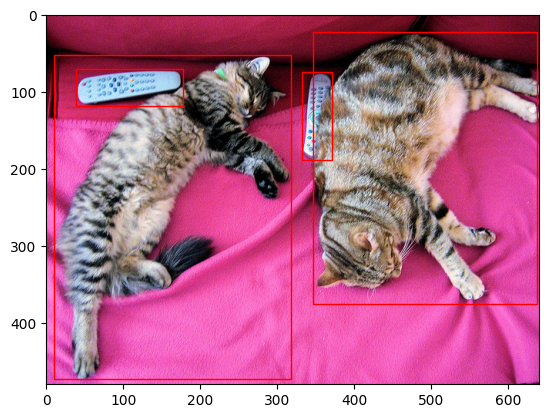

In [3]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 假设你的数据是这样的
data = [{'scores': torch.tensor([0.4018, 0.4405, 0.4280, 0.3284], device='cuda:0'),
         'labels': ['a cat', 'a remote control', 'a cat', 'a remote control'],
         'boxes': torch.tensor([[346.2108,  22.1861, 637.4618, 374.6660],
                                 [ 38.3553,  70.1097, 176.6924, 117.9167],
                                 [ 10.1973,  52.4855, 316.9341, 472.7589],
                                 [332.0846,  74.4275, 371.0870, 187.9795]], device='cuda:0')}]

fig, ax = plt.subplots(1)

ax.imshow(image)

# 遍历边界框信息进行可视化
for box_info in data[0]['boxes'].cpu():
    x_min, y_min, x_max, y_max = box_info
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# 显示图像
plt.show()

In [5]:
image = Image.open('/home/lixiang/codebase/embodied-CoT/scripts/generate_embodied_data/bounding_boxes/output.png')

In [17]:
text = "a cat. a remote control."
device = 'cuda:0'
# model = model.to(device)
inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.3,
    text_threshold=0.2,
    target_sizes=[image.size[::-1]]
)
print(results)

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


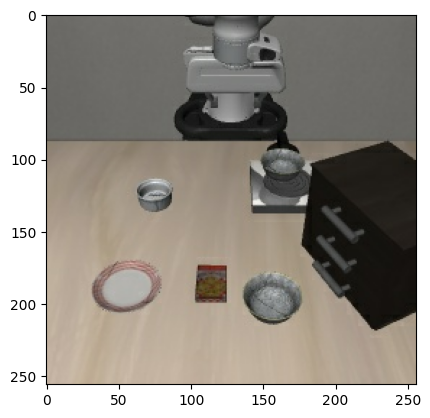

In [14]:
fig, ax = plt.subplots(1)

ax.imshow(image)

# 遍历边界框信息进行可视化
for box_info in results[0]['boxes'].cpu():
    x_min, y_min, x_max, y_max = box_info
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# 显示图像
plt.show()